In [1]:
# !pip install tensorflow

In [2]:
import tensorflow as tf
import pandas as pd

# Import Layers, Optimizers, and the Model Creation Function:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam  # Optimize training and weight calculation
from tensorflow.keras.models import Model  # Combine our layers and for the Neural Network

In [32]:
data = pd.read_csv('C:/Users/migue/Desktop/MachineLearning/prueba/rileys_data.csv')
data.head(1)

,AIRLINE,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,DEP_DELAY,CRS_ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,...,dest_SNWD,dest_AWND,dest_PRCP,CRS_DEP_Datetime,15_DELAYED,year,month,day,day_of_week,hour
0,Spirit Air Lines,MCO,"Orlando, FL",DFW,"Dallas/Fort Worth, TX",-2.0,2041,-1.0,0.0,0.0,...,0.0,55.0,8.0,2020-02-23 18:40:00,0,2020,2,23,6,18


In [33]:
data=data[(data['ORIGIN']=='ATL')]
print(len(data))

99510


In [31]:
print('Delayed flights: ',len(data[data['15_DELAYED']==1]))

Delayed flights:  70336


In [5]:
data.columns

Index(['AIRLINE', 'ORIGIN', 'ORIGIN_CITY', 'DEST', 'DEST_CITY', 'DEP_DELAY',
       'CRS_ARR_TIME', 'ARR_DELAY', 'CANCELLED', 'DIVERTED', 'DISTANCE',
       'ori_TMIN', 'ori_TMAX', 'ori_SNOW', 'ori_SNWD', 'ori_AWND', 'ori_PRCP',
       'dest_TMIN', 'dest_TMAX', 'dest_SNOW', 'dest_SNWD', 'dest_AWND',
       'dest_PRCP', 'CRS_DEP_Datetime', '15_DELAYED', 'year', 'month', 'day',
       'day_of_week', 'hour'],
      dtype='object')

In [6]:
used_data=data.loc[:,~data.columns.isin(['ORIGIN_CITY', 'DEST_CITY','DEP_DELAY','ARR_DELAY','CANCELLED','DIVERTED','CRS_DEP_Datetime','CRS_ARR_TIME'])].copy()
used_data.columns

Index(['AIRLINE', 'ORIGIN', 'DEST', 'DISTANCE', 'ori_TMIN', 'ori_TMAX',
       'ori_SNOW', 'ori_SNWD', 'ori_AWND', 'ori_PRCP', 'dest_TMIN',
       'dest_TMAX', 'dest_SNOW', 'dest_SNWD', 'dest_AWND', 'dest_PRCP',
       '15_DELAYED', 'year', 'month', 'day', 'day_of_week', 'hour'],
      dtype='object')

In [7]:

# Define a function to replace infrequent categories with 'Other'
def replace_infrequent_categories(df, categorical_cols, threshold=0.05, other_label='Other'):
    for col in categorical_cols:
        counts = df[col].value_counts(normalize=True)
        infrequent_categories = counts[counts < threshold].index
        df[col] = df[col].replace(infrequent_categories, other_label)
    return df

# Define threshold for infrequent categories (adjust as needed)
threshold = 0.035

In [8]:
X = used_data.drop(['15_DELAYED'], axis=1)
y = used_data['15_DELAYED']


categorical_cols = ['AIRLINE','ORIGIN','DEST']
numeric_cols = [col for col in used_data.columns if col not in categorical_cols]
numeric_cols.remove('15_DELAYED')
# Replace infrequent categories with 'Other'
df_processed = replace_infrequent_categories(X, categorical_cols, threshold)

In [9]:
print('airline  ',len(used_data['AIRLINE'].unique()))
print('origin  ',len(used_data['ORIGIN'].unique()))
print('dest  ',len(used_data['DEST'].unique()))
print('airline  ',len(df_processed['AIRLINE'].unique()))
print('origin  ',len(df_processed['ORIGIN'].unique()))
print('dest  ',len(df_processed['DEST'].unique()))

airline   17
origin   221
dest   220
airline   11
origin   6
dest   6


In [10]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Inicializar el codificador OneHotEncoder sin matriz dispersa

encoder = OneHotEncoder(sparse_output=False)

# Ajustar y transformar los datos categóricos usando OneHotEncoder
encoded_data = encoder.fit_transform(df_processed[categorical_cols])

# Crear un DataFrame con las columnas codificadas
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))



# Concatenar el DataFrame original con el DataFrame codificado
encoded_data = pd.concat([df_processed.reset_index(drop=True), encoded_df], axis=1)

# Eliminar las columnas originales categóricas del DataFrame original
encoded_data.drop(categorical_cols, axis=1, inplace=True)


In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
encoded_data[numeric_cols] = scaler.fit_transform(encoded_data[numeric_cols])
encoded_data.head(1)


,DISTANCE,ori_TMIN,ori_TMAX,ori_SNOW,ori_SNWD,ori_AWND,ori_PRCP,dest_TMIN,dest_TMAX,dest_SNOW,...,ORIGIN_DEN,ORIGIN_DFW,ORIGIN_ORD,ORIGIN_Other,DEST_ATL,DEST_CLT,DEST_DEN,DEST_DFW,DEST_ORD,DEST_Other
0,0.452015,0.043486,0.323359,-0.103983,-0.14447,-0.288833,-0.311327,-0.347657,-0.623824,-0.103003,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [12]:
from sklearn.model_selection import train_test_split

X = encoded_data # Asegúrate de reemplazar 'TARGET_COLUMN' con el nombre de tu columna objetivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

In [16]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

# Definir el modelo
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(1, activation='softmax')
])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Compilar el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy',tf.keras.metrics.Recall()])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=30,validation_data=(X_test, y_test),callbacks=[early_stopping])




c:\Users\migue\Desktop\MachineLearning\prueba\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


c:\Users\migue\Desktop\MachineLearning\prueba\venv\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


31379/31397 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2194 - loss: 0.4919 - recall_3: 1.0000

c:\Users\migue\Desktop\MachineLearning\prueba\venv\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


31397/31397 ━━━━━━━━━━━━━━━━━━━━ 42s 1ms/step - accuracy: 0.2194 - loss: 0.4919 - recall_3: 1.0000 - val_accuracy: 0.2194 - val_loss: 0.4837 - val_recall_3: 1.0000
Epoch 2/30
31397/31397 ━━━━━━━━━━━━━━━━━━━━ 38s 1ms/step - accuracy: 0.2196 - loss: 0.4807 - recall_3: 1.0000 - val_accuracy: 0.2194 - val_loss: 0.4789 - val_recall_3: 1.0000
Epoch 3/30
31397/31397 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - accuracy: 0.2202 - loss: 0.4790 - recall_3: 1.0000 - val_accuracy: 0.2194 - val_loss: 0.4772 - val_recall_3: 1.0000
Epoch 4/30
31397/31397 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step - accuracy: 0.2198 - loss: 0.4774 - recall_3: 1.0000 - val_accuracy: 0.2194 - val_loss: 0.4763 - val_recall_3: 1.0000
Epoch 5/30
31397/31397 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step - accuracy: 0.2199 - loss: 0.4766 - recall_3: 1.0000 - val_accuracy: 0.2194 - val_loss: 0.4766 - val_recall_3: 1.0000
Epoch 6/30
31397/31397 ━━━━━━━━━━━━━━━━━━━━ 31s 993us/step - accuracy: 0.2202 - loss: 0.4761 - recall_3: 1.0000 - val_accuracy: 0.2194 -

  234/31397 ━━━━━━━━━━━━━━━━━━━━ 20s 652us/step

c:\Users\migue\Desktop\MachineLearning\prueba\venv\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


31397/31397 ━━━━━━━━━━━━━━━━━━━━ 23s 725us/step


c:\Users\migue\Desktop\MachineLearning\prueba\venv\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


7850/7850 ━━━━━━━━━━━━━━━━━━━━ 6s 738us/step


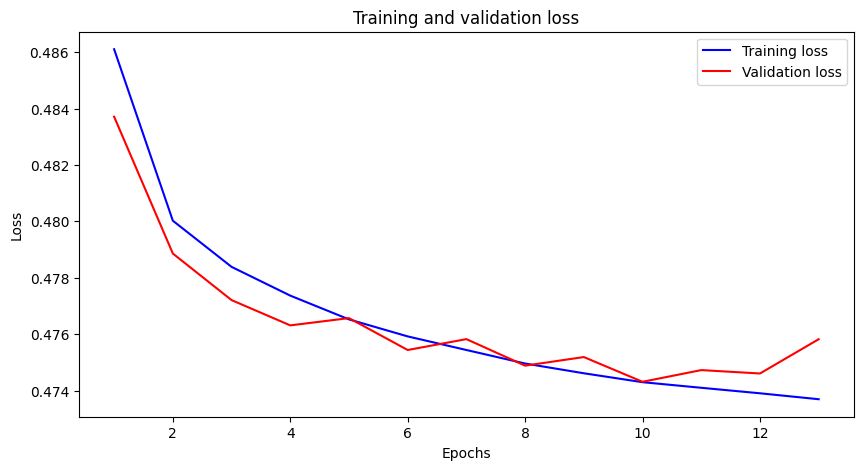

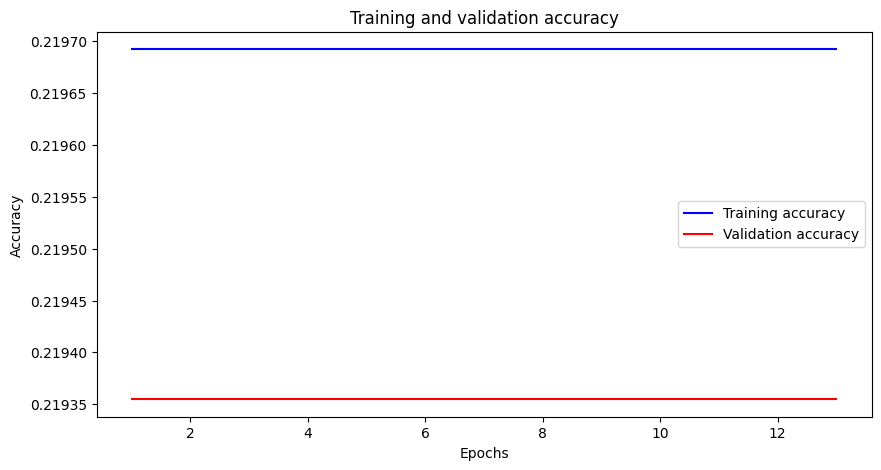

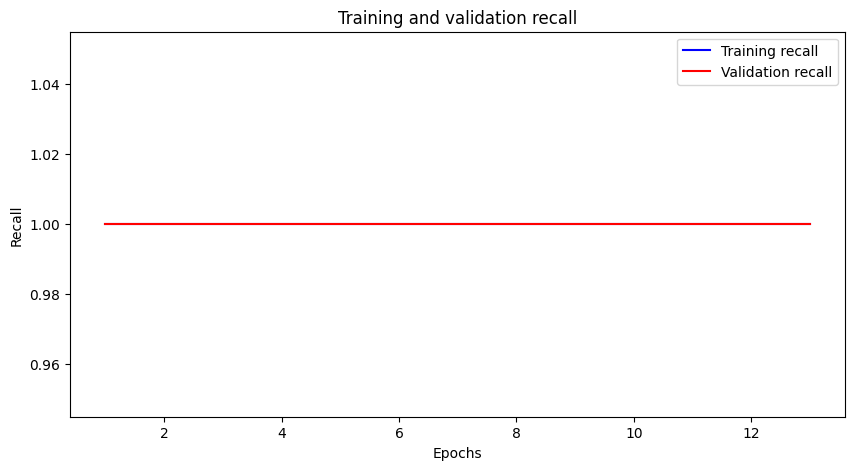

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

# Obtener predicciones del conjunto de entrenamiento y validación
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_test)

# Calcular la sensibilidad (recall)
train_recall = recall_score(y_train, train_predictions.round())
val_recall = recall_score(y_test, val_predictions.round())

# Obtener información de la historia del entrenamiento
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plotear la pérdida
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotear la precisión
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotear la sensibilidad (recall)
plt.figure(figsize=(10, 5))
plt.plot(epochs, [train_recall]*len(epochs), 'b', label='Training recall')
plt.plot(epochs, [val_recall]*len(epochs), 'r', label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()


In [19]:
from sklearn.metrics import recall_score,precision_score,accuracy_score,classification_report
val_recall = recall_score(y_test, val_predictions.round())
val_precision = precision_score(y_test, val_predictions.round())
val_accuracy = accuracy_score(y_test, val_predictions.round())
classification_report_1 = classification_report(y_test, val_predictions.round())
print("recall value: ",val_recall)
print("precision value: ",val_precision)
print("accuracy value: ",val_accuracy)
print(classification_report_1)

c:\Users\migue\Desktop\MachineLearning\prueba\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\migue\Desktop\MachineLearning\prueba\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


recall value:  1.0
precision value:  0.219354787337811
accuracy value:  0.219354787337811
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    196077
           1       0.22      1.00      0.36     55096

    accuracy                           0.22    251173
   macro avg       0.11      0.50      0.18    251173
weighted avg       0.05      0.22      0.08    251173



c:\Users\migue\Desktop\MachineLearning\prueba\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
